In [70]:
import pandas as pd
import numpy as np
import math
from sklearn import datasets, linear_model, metrics, feature_extraction, model_selection
from matplotlib import pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [64]:
df = pd.read_csv("train_dataset.csv")

In [65]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,target
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,DFW,190,15.0,13.0,1
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,DTW,207,9.0,24.0,1
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,RDU,532,3.0,27.0,0
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,LGA,1147,6.0,8.0,1
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,FLL,1972,9.0,21.0,1


In [4]:
df["TailNum"] = df["TailNum"].fillna("UNKNOWN")

In [5]:
df['TaxiOut'] = df['TaxiOut'].fillna(df['TaxiOut'].mean())

df['AirTime'] = df['AirTime'].fillna(df['AirTime'].mean())

df['DepTime'] = df['DepTime'].fillna(df['DepTime'].mean())

df['ArrTime'] = df['ArrTime'].fillna(df['ArrTime'].mean())

df['TaxiIn'] = df['TaxiIn'].fillna(df['TaxiIn'].mean())

In [6]:
seasons = ("-", "W", "W", "P", "P", "P", "S", "S", "S", "A", "A", "A", "W")
df["Season"] = df["Month"].map(lambda m: seasons[m])

In [7]:
def reclassMean(frame, targetSrc, clsName, meanName, targetExtractor = lambda f, c: f.groupby(c)["target"].mean()):
    def getMean(c, meanInfo): 
        if c not in meanInfo:
            meanInfo[c] = meanInfo.mean()
        return meanInfo[c]
    meanInfo = targetExtractor(targetSrc, clsName)
    frame[meanName] = frame[clsName].map(lambda c: getMean(c, meanInfo))

In [8]:
reclassMean(df, df, "UniqueCarrier", "CarrierChance")
reclassMean(df, df, "Dest", "DestChance")
reclassMean(df, df, "Origin", "OriginChance")
reclassMean(df, df, "TailNum", "PlaneChance")
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,target,Season,CarrierChance,DestChance,OriginChance,PlaneChance
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,DFW,190,15.0,13.0,1,W,0.330748,0.264919,0.249355,0.315904
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,DTW,207,9.0,24.0,1,W,0.238788,0.225465,0.235487,0.199134
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,RDU,532,3.0,27.0,0,W,0.302457,0.306310,0.235227,0.324830
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,LGA,1147,6.0,8.0,1,W,0.302457,0.332585,0.263668,0.297125
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,FLL,1972,9.0,21.0,1,W,0.231669,0.321040,0.297125,0.244681


In [60]:
in_time = df[df["target"] == 0]
speed = in_time["Distance"] / (in_time["ArrTime"] - in_time["DepTime"])
speed_df = pd.concat([in_time.loc[:, "TailNum"], speed], axis=1, join='inner')

In [61]:
s = lambda f, c: f.groupby(c)[0].mean()
reclassMean(df, speed_df, "TailNum", "Speed", s)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,TaxiOut,target,Season,CarrierChance,DestChance,OriginChance,PlaneChance,Speed,EstTime,TimeDiff
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,...,13.0,1,W,0.330748,0.264919,0.249355,0.315904,4.069892,27.459046,74.540954
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,...,24.0,1,W,0.238788,0.225465,0.235487,0.199134,4.216614,30.213599,79.786401
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,...,27.0,0,W,0.302457,0.306310,0.235227,0.324830,2.733938,90.009904,162.990096
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,...,8.0,1,W,0.302457,0.332585,0.263668,0.297125,2.687057,196.276719,127.723281
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,...,21.0,1,W,0.231669,0.321040,0.297125,0.244681,5.109602,270.353329,348.646671


In [62]:
df["EstTime"] = df["Distance"] / df["Speed"]
df["TimeDiff"] = df["ArrTime"] - df["DepTime"] - df["EstTime"]
df.sort_values(by='TailNum').loc[:, ["TailNum", "AirTime", "Distance", "Speed", "EstTime", "TimeDiff", "target"]].head(10)

,TailNum,AirTime,Distance,Speed,EstTime,TimeDiff,target
1326249,80009E,44.0,249,3.316031,75.089772,54.910228,0
2983763,80009E,92.0,574,3.316031,173.098511,-72.098511,0
2067030,80009E,97.0,574,3.316031,173.098511,-81.098511,0
3377604,80009E,81.0,651,3.316031,196.319043,160.680957,0
1074709,80009E,61.0,398,3.316031,120.023009,39.976991,0
666777,80009E,67.0,392,3.316031,118.213617,3.786383,0
907070,80009E,88.0,499,3.316031,150.481110,43.518890,0
3073681,80009E,71.0,324,3.316031,97.707174,31.292826,0
1367601,80009E,79.0,616,3.316031,185.764256,-5.764256,0
2057888,80009E,83.0,456,3.316031,137.513800,53.486200,0


In [32]:
dropped_cols = ["UniqueCarrier", "Origin", "Dest", "FlightNum", "TailNum", "Month", "DayofMonth"]
oh_cols = ["Season", "DayOfWeek"]
clf_num = df.drop(dropped_cols + oh_cols + ["target"], axis=1)
clf_oh = pd.get_dummies(df.loc[:, oh_cols], columns=oh_cols, dummy_na=False)
clf_df = pd.concat([clf_num, clf_oh], axis=1, join='inner')

In [33]:
clf_df.head()

,DepTime,ArrTime,AirTime,Distance,TaxiIn,TaxiOut,CarrierChance,DestChance,OriginChance,PlaneChance,...,Season_P,Season_S,Season_W,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,1007.0,1109.0,34.0,190,15.0,13.0,0.330748,0.264919,0.249355,0.315904,...,0,0,1,0,1,0,0,0,0,0
1,1411.0,1521.0,37.0,207,9.0,24.0,0.238788,0.225465,0.235487,0.199134,...,0,0,1,0,1,0,0,0,0,0
2,859.0,1112.0,103.0,532,3.0,27.0,0.302457,0.306310,0.235227,0.324830,...,0,0,1,0,1,0,0,0,0,0
3,1835.0,2159.0,130.0,1147,6.0,8.0,0.302457,0.332585,0.263668,0.297125,...,0,0,1,0,1,0,0,0,0,0
4,1305.0,1924.0,229.0,1972,9.0,21.0,0.231669,0.321040,0.297125,0.244681,...,0,0,1,0,1,0,0,0,0,0


In [34]:
labels = df["target"]
clf_train, clf_test, label_train, label_test = model_selection.train_test_split(clf_df, labels, test_size = 0.3)

In [35]:
clf = linear_model.LogisticRegression()
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5]}
opt = model_selection.GridSearchCV(clf, param_grid, cv=3, n_jobs=2, return_train_score=True)

In [ ]:
opt.fit(clf_train, label_train)

In [22]:
opt.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
opt.cv_results_

{'mean_fit_time': array([ 77.33347034,  58.42900793,  69.325869  ,  63.20727634,
         60.52626777,  64.72532058]),
 'mean_score_time': array([ 0.229273  ,  0.28210179,  0.26689386,  0.29987661,  0.2843678 ,
         0.25156029]),
 'mean_test_score': array([ 0.72308597,  0.72092692,  0.72486513,  0.72232539,  0.72265351,
         0.72467641]),
 'mean_train_score': array([ 0.72317095,  0.72074086,  0.72498516,  0.72245052,  0.72235372,
         0.7247351 ]),
 'param_C': masked_array(data = [0.01 0.05 0.1 0.5 1 5],
              mask = [False False False False False False],
        fill_value = ?),
 'params': [{'C': 0.01},
  {'C': 0.05},
  {'C': 0.1},
  {'C': 0.5},
  {'C': 1},
  {'C': 5}],
 'rank_test_score': array([3, 6, 1, 5, 4, 2], dtype=int32),
 'split0_test_score': array([ 0.72514007,  0.7206989 ,  0.72528191,  0.71980137,  0.72405668,
         0.72318361]),
 'split0_train_score': array([ 0.72542709,  0.72073646,  0.72555304,  0.71979063,  0.72407591,
         0.72350914]),
 'spl

In [24]:
pred = opt.predict(clf_test)

In [25]:
predpr = opt.predict_proba(clf_test)

In [26]:
metrics.accuracy_score(label_test, pred)

0.72392577939246383

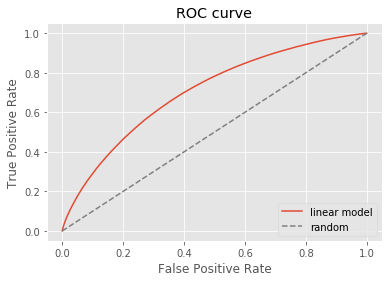

In [27]:
fpr, tpr, _ = metrics.roc_curve(label_test, predpr[:,1])
plt.plot(fpr, tpr, label = 'linear model')
plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = "lower right");

In [28]:
metrics.roc_auc_score(label_test, predpr[:,1])

0.70411506356602116

In [268]:
test_df = pd.read_csv("test_dataset.csv")

In [269]:
test_df["TailNum"] = test_df["TailNum"].fillna("UNKNOWN")

test_df['TaxiOut'] = test_df['TaxiOut'].fillna(df['TaxiOut'].mean())

test_df['AirTime'] = test_df['AirTime'].fillna(df['AirTime'].mean())

test_df['DepTime'] = test_df['DepTime'].fillna(df['DepTime'].mean())

test_df['ArrTime'] = test_df['ArrTime'].fillna(df['ArrTime'].mean())

test_df['TaxiIn'] = test_df['TaxiIn'].fillna(df['TaxiIn'].mean())

In [270]:
test_df["Season"] = test_df["Month"].map(lambda m: seasons[m])

In [283]:
reclassMean(test_df, df, "UniqueCarrier", "CarrierChance")
reclassMean(test_df, df, "Dest", "DestChance")
reclassMean(test_df, df, "Origin", "OriginChance")
reclassMean(test_df, df, "TailNum", "Speed")

In [284]:
test_clf_df = test_df.drop(dropped_cols, axis=1)
test_clf_cat = test_clf_df[oh_cols]

In [273]:
dv = feature_extraction.DictVectorizer(sparse=False)
test_clf_oh = dv.fit_transform(test_clf_cat.T.to_dict().values())

In [285]:
test_clf_num = test_clf_df.drop(oh_cols + ["Id"], axis=1)

In [286]:
test_clf = np.concatenate((test_clf_num, test_clf_oh), axis=1)

In [287]:
test_clf.shape

(3504864, 17)

In [288]:
test_pred = opt.predict_proba(test_clf)

In [289]:
test_pred[:, 1]

array([ 0.55668857,  0.53579349,  0.50382141, ...,  0.29191245,
        0.3603659 ,  0.29777507])

In [290]:
test_pred_df = pd.DataFrame(test_pred[:, 1], columns=["Prediction1"])

In [291]:
test_pred_df.index.name = "Id"

In [292]:
test_pred_df.head()

,Prediction1
Id,
0,0.556689
1,0.535793
2,0.503821
3,0.416603
4,0.387405


In [293]:
test_pred_df.to_csv("sample_1.csv")